In [ ]:
import sys
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt
import jax
from jax import numpy as jnp

sys.path.append("..")
import L63_modified as L63
import solvers
import utils
import base_optim

reload(L63)
reload(solvers)
reload(utils)
reload(base_optim)

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray

In [ ]:
def get_initial_values():
    # Initial true state
    u0 = jnp.array([0, 1, -1], dtype=float)

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return u0, un0


def plot(cs, u_errors, gs, tls):
    num_iters, num_params = cs.shape
    ils = np.arange(num_iters)

    # Make sure there's one more axes than there are parameters (for plotting
    # the error).
    q = (num_params + 1) // 2
    fig, axs = plt.subplots(
        q if num_params % 2 == 1 else q + 1, 2, figsize=(10, 8)
    )
    # Delete last axes if unused.
    if num_params % 2 == 0:
        plt.delaxes(axs[-1, 0])

    i, j = 0, 0
    for k, c in enumerate(cs.T):
        g = gs[k] if k < len(gs) else 0

        ax = axs[i, j]
        ax.hlines(g, ils[0], ils[-1], label=f"g{k}", color="black")
        ax.plot(ils, c, label=f"c{k}")
        ax.legend()
        ax.set_title(f"c{k} vs {f'g{k}' if k < len(gs) else 0}")
        ax.set_xlabel("Iteration number")

        # Iterate through axs first from left to right, then top to bottom.
        if j == 1:
            i += 1
            j = 0
        else:
            j += 1

    ax = axs[-1, -1]
    ax.plot(tls[1:], u_errors)
    ax.set_yscale("log")
    ax.set_title("Relative error in $u$")
    ax.set_xlabel("Time")

    fig.tight_layout()

    return fig, axs

In [ ]:
# System evolution parameters
sigma, rho, beta = g1, g2, g3 = 10, 28, 8 / 3
c1, c2, c3 = g1, g2, g3
c1 *= 1.1
c2 *= 0.9
c3 *= 1.1
μ = 20

# Use ODE with extra "fake" parameters for nudged system.
fake = (1, 2)
modified = len(fake) > 0

gs = jnp.array([g1, g2, g3])
bs = jnp.array([])
cs = jnp.array([c1, c2, c3, *fake])

observed_slice = jnp.s_[:]
system = L63.L63(μ, gs, bs, cs, observed_slice, modified=modified)
solver = solvers.RK4(system)
solver = solvers.TwoStepAdamsBashforth(system, solver)

optimizer = base_optim.LevenbergMarquardt(system, 1e-2)

regularize = False
if regularize:
    optimizer.learning_rate = 1e0
    regularizer = base_optim.Regularizer(system, 1)
    optimizer = base_optim.OptimizerChain(
        system, 1e-2, [optimizer, regularizer], [0.9, 0.1]
    )

# Simulation parameters
dt = 0.01
T0, Tf = 0, 500
t_relax = 1

cs, u_errors, tls, *_ = utils.run_update(
    system,
    solver,
    dt,
    T0,
    Tf,
    t_relax,
    *get_initial_values(),
    optimizer=optimizer,
)

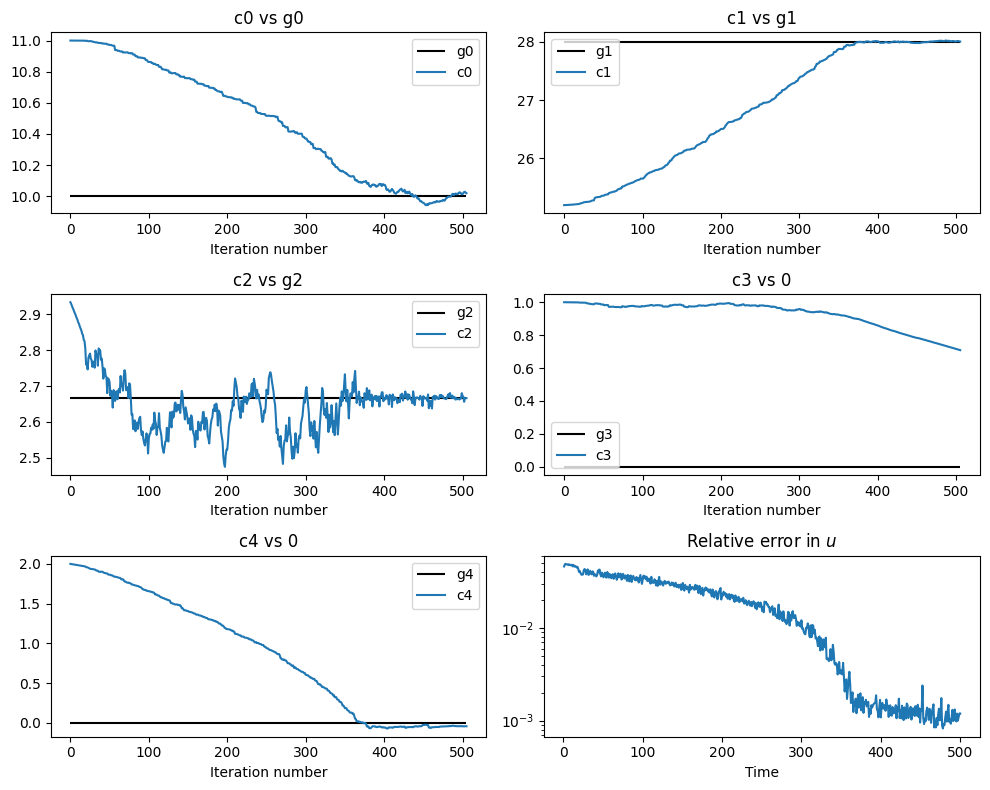

In [ ]:
fig, axs = plot(cs, u_errors, gs, tls)
plt.show()

# Use regularization

In [ ]:
# System evolution parameters
sigma, rho, beta = g1, g2, g3 = 10, 28, 8 / 3
c1, c2, c3 = g1, g2, g3
c1 *= 1.1
c2 *= 0.9
c3 *= 1.1
μ = 20

# Use ODE with extra "fake" parameters for nudged system.
fake = (1, 2)
modified = len(fake) > 0

gs = jnp.array([g1, g2, g3])
bs = jnp.array([])
cs = jnp.array([c1, c2, c3, *fake])

observed_slice = jnp.s_[:]
system = L63.L63(μ, gs, bs, cs, observed_slice, modified=modified)
solver = solvers.RK4(system)
solver = solvers.TwoStepAdamsBashforth(system, solver)

optimizer = base_optim.LevenbergMarquardt(system, 1e-2)

regularize = True
if regularize:
    optimizer.learning_rate = 1e0
    regularizer = base_optim.Regularizer(system, 1)
    optimizer = base_optim.OptimizerChain(
        system, 1e-2, [optimizer, regularizer], [0.9, 0.1]
    )

# Simulation parameters
dt = 0.01
T0, Tf = 0, 500
t_relax = 1

cs, u_errors, tls, *_ = utils.run_update(
    system,
    solver,
    dt,
    T0,
    Tf,
    t_relax,
    *get_initial_values(),
    optimizer=optimizer,
)

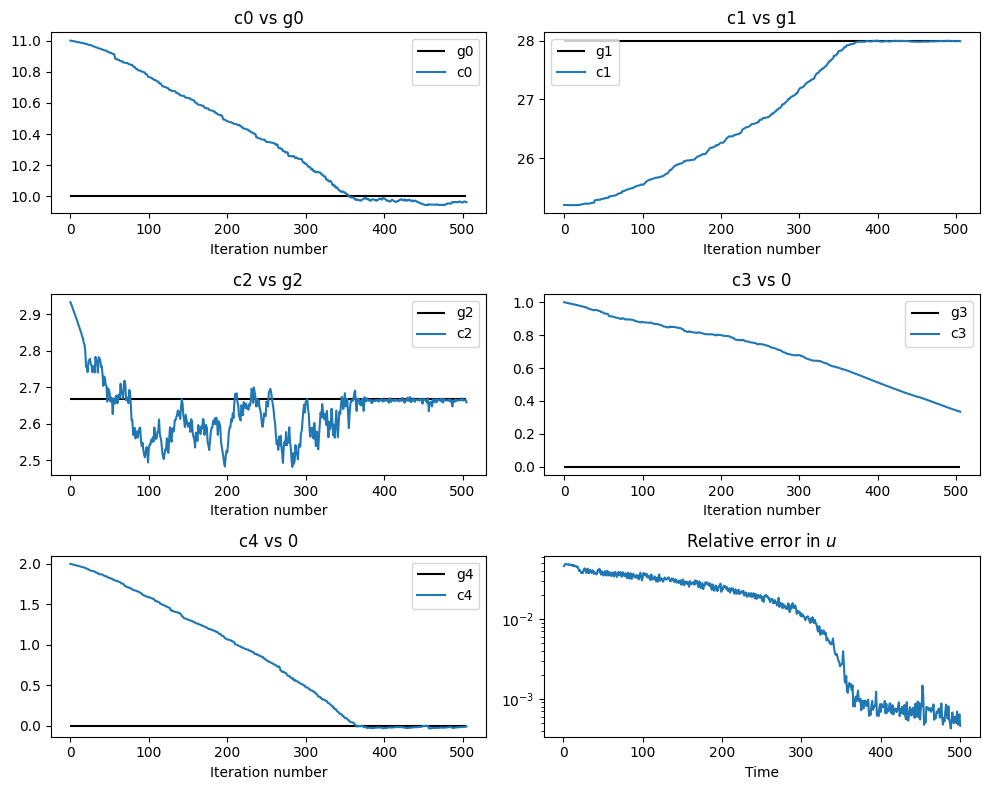

In [ ]:
fig, axs = plot(cs, u_errors, gs, tls)
plt.show()